In [2]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.optimize import curve_fit

# plot speedscaling for all wBA

In [153]:
home = os.path.expanduser("~")

net = f'fb_linear'
filepath = f'{home}/Documents/Simulations/motion_anticipation_network/{net}'

# load dataframe 
response_data = pd.read_csv(f'{filepath}/responses_RG_wAB_zoom.csv')


# load dataframe 
df = pd.read_csv(f'{filepath}/anticipation_data_wAB_zoom.csv')


print(df.columns)

# calculate anticipation with respect to V_drive
df['ant_RG_drive_time']  =  df['peak_drive'] - df['peak_RG'] 
df['ant_RG_drive_space'] = df['ant_RG_drive_time']* df['speed']

# calculate anticipation with respect to 
df['ant_RG_bar_time']  = df['tp_rf_GC_mid'] - df['peak_RG'] 
df['ant_RG_bar_space'] = df['ant_RG_bar_time']* df['speed']

# calculate anticipation with respect to 
df['ant_RB_bar_time']  = df['tp_rf_GC_mid'] - df['peak_RB'] 
df['ant_RB_bar_space'] = df['ant_RB_bar_time']* df['speed']



df['wTOT'] = -1*df['wTOT']
df['wTOT'] = df['wTOT'].round()
df['speed'] = df['speed'].round(2)
# multiple heatmaps, keeping w+ fixed and changing w-
#dfgrouped = df.groupby(['wAB'])


speeds = df['speed'].unique()#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0]

df['wBA'].unique(), df['wAB'].unique()




Index(['Unnamed: 0', 'wTOT', 'tauTOT', 'wBA', 'wAB', 'tauA', 'tauB', 'mu',
       'speed', 'peak_RG', 'peak_RB', 'peak_drive', 'tp_rf_GC_mid',
       'peak_RG_pooling', 'peak_RB_pooling', 'onset_RB', 'onset_RG', 'wGA'],
      dtype='object')


(array([ 1.  ,  2.03,  3.07,  4.1 ,  5.14,  6.17,  7.21,  8.24,  9.28,
        10.31, 11.34, 12.38, 13.41, 14.45, 15.48, 16.52, 17.55, 18.59,
        19.62, 20.66, 21.69, 22.72, 23.76, 24.79, 25.83, 26.86, 27.9 ,
        28.93, 29.97, 31.  ]),
 array([10.]))

In [154]:
speeds


array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15,
       1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65, 1.7 ,
       1.75, 1.8 , 1.85, 1.9 , 1.95])

In [155]:
# dl = df[df['wBA'] == 1.0]
# #dl = df[df['wTOT'] == -101.0]
# #dl = dl[dl['speed'] == 1.05]
# idx = dl['ant_RG_bar_space'].index
# len(idx)


# for x,i in enumerate(idx):


#     r = response_data[f'{i}'].dropna()
#     tps = len(r)
#     speed = dl['speed'][dl.index[x]]
#     print(tps,speed)
#     tpm = dl['tp_rf_GC_mid'][dl.index[x]]
#     print(tpm)
#     time = (np.arange(0,tps)*0.01 -tpm)*speed
#     plt.plot(time,r,label = f'{i}')
# plt.legend()


/tmp/ipykernel_970025/2010535383.py:34: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sg = subg.get_group(w2)
/tmp/ipykernel_970025/2010535383.py:112: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sg = subg.get_group(w2)


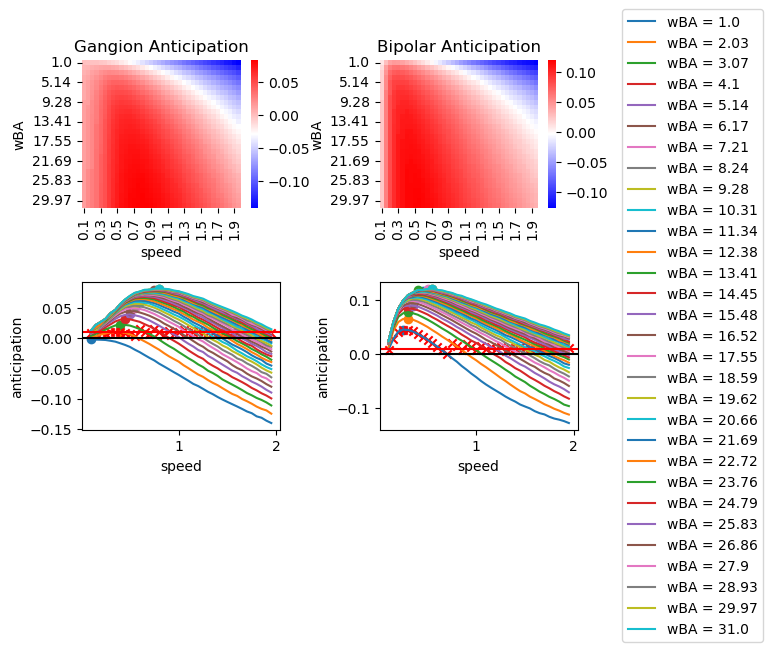

In [177]:

figure = plt.figure()
gs = figure.add_gridspec(2,2)

figure.subplots_adjust(wspace = 0.5,hspace = 0.5)


var = 'ant_RG_bar_space'
fig = figure.add_subplot(gs[0,0])
fig.set_title('Gangion Anticipation')
ax = figure.add_subplot(gs[1,0])
#weights = [0.0,10.0,50.0,100.0]

# plot heatmap for beta
g_heatmap = df.pivot_table(index = 'wBA',columns = 'speed',values = var, aggfunc = 'mean')
sns.heatmap(g_heatmap, ax = fig, cmap = 'bwr')#,  vmin=-0.2, vmax=0.2)

subg = df.groupby(['wBA'])
#ax.set_xscale('log')


# get values for which difference across speed is minimal
diffsdf = pd.DataFrame(columns = ['diff', 'mu','wTOT','tauTOT', 'tauA', 'wAB'])
pref_speeds_G = []
pref_amp_G = []
weights_G = []
anips_G = []

best_weights_G = []
vals_G = []
best_amp_G = []

# get values that yield same anticipation time across speeds
for x,w2 in enumerate(subg.groups):
    sg = subg.get_group(w2)

    cur  = sg[var].values
    speeds = sg['speed'].values
    maxi = np.argmax(cur)
    ax.plot(sg['speed'], sg[var], label = f'wBA = {w2}')#,color = scalarMap.to_rgba(x))
    ax.scatter(speeds[maxi],cur[maxi])

    pref_speeds_G.append(speeds[maxi])
    pref_amp_G.append(cur[maxi])
    weights_G.append(w2)
    anips_G.append(cur)

anipis_G = np.asarray(anips_G)
goal = 0.01
for i in range(len(speeds)):
    
    try:
        best_idx_upper = np.nonzero(anipis_G[:,i] >=goal)[0][0]
        best_aniup_er = np.abs(anipis_G[best_idx_upper,i]-goal)
    except:
        best_aniup_er == 100

    try: 
        best_idx_lower = np.nonzero(anipis_G[:,i] <=goal)[0][-1]
        best_anilo_er = np.abs(anipis_G[best_idx_lower,i]-goal)
    except: 
        best_anilo_er = 100

    if best_aniup_er > best_anilo_er:
        best_weight = weights_G[best_idx_lower]
        best_ani = anipis_G[best_idx_lower,i]
    else:
        best_weight = weights_G[best_idx_upper]
        best_ani = anipis_G[best_idx_upper,i]

    best_weights_G.append(best_weight)

    vals_G.append(best_ani)
    best_amp_G.append(best_ani)
    ax.scatter(speeds[i],best_ani, marker = 'x', color = 'r')

#ax.legend()
plt.axhline(0.0, color = 'k')
plt.axhline(goal, color = 'r')
ax.set_xlabel('speed')
ax.set_ylabel('anticipation')




var = 'ant_RB_bar_space'
fig = figure.add_subplot(gs[0,1])
fig.set_title('Bipolar Anticipation')
ax = figure.add_subplot(gs[1,1])
#weights = [0.0,10.0,50.0,100.0]

# plot heatmap for beta
g_heatmap = df.pivot_table(index = 'wBA',columns = 'speed',values = var, aggfunc = 'mean')
sns.heatmap(g_heatmap, ax = fig, cmap = 'bwr')#,  vmin=-0.2, vmax=0.2)

subg = df.groupby(['wBA'])
#ax.set_xscale('log')


# get values for which difference across speed is minimal
diffsdf = pd.DataFrame(columns = ['diff', 'mu','wTOT','tauTOT', 'tauA', 'wAB'])
pref_speeds_B = []
pref_amp_B = []
weights_B = []
anipis_B = []

best_weights_B = []
vals_B = []
best_amp_B = []

# get values that yield same anticipation time across speeds
for x,w2 in enumerate(subg.groups):
    sg = subg.get_group(w2)

    cur  = sg[var].values
    speeds = sg['speed'].values
    maxi = np.argmax(cur)
    ax.plot(sg['speed'], sg[var])#,color = scalarMap.to_rgba(x))
    ax.scatter(speeds[maxi],cur[maxi])

    pref_speeds_B.append(cur[maxi])
    weights_B.append(w2)
    anipis_B.append(cur)


anipis_B = np.asarray(anipis_B)
goal = 0.01
for i in range(len(speeds)):
    
    try:
        best_idx_upper = np.nonzero(anipis_B[:,i] >=goal)[0][0]
        best_aniup_er = np.abs(anipis_B[best_idx_upper,i]-goal)
    except:
        best_aniup_er == 100

    try: 
        best_idx_lower = np.nonzero(anipis_B[:,i] <=goal)[0][-1]
        best_anilo_er = np.abs(anipis_B[best_idx_lower,i]-goal)
    except: 
        best_anilo_er = 100

    if best_aniup_er > best_anilo_er:
        best_weight = weights_B[best_idx_lower]
        best_ani = anipis_B[best_idx_lower,i]
    else:
        best_weight = weights_B[best_idx_upper]
        best_ani = anipis_B[best_idx_upper,i]

    best_weights_B.append(best_weight)

    vals_B.append(best_ani)
    best_amp_B.append(best_ani)
    ax.scatter(speeds[i],best_ani, marker = 'x', color = 'r')



#ax.legend()
plt.axhline(0.0, color = 'k')
plt.axhline(goal, color = 'r')
ax.set_xlabel('speed')
ax.set_ylabel('anticipation')
figure.legend(bbox_to_anchor = (1.2,1))

## optimal weight for a set amout of anticipation 

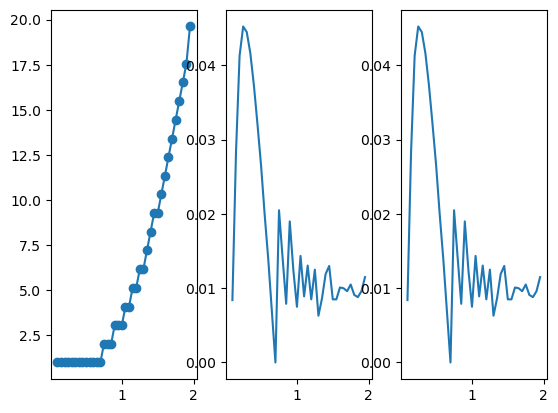

In [178]:

fig = plt.figure()
gs = fig.add_grispec()
ax = fig.add_subplot(131)
plt.plot(speeds,best_weights_B)
plt.scatter(speeds,best_weights_B)

ax = fig.add_subplot(132)
plt.plot(speeds,vals_B)


ax = fig.add_subplot(133)
plt.plot(speeds,vals_B)

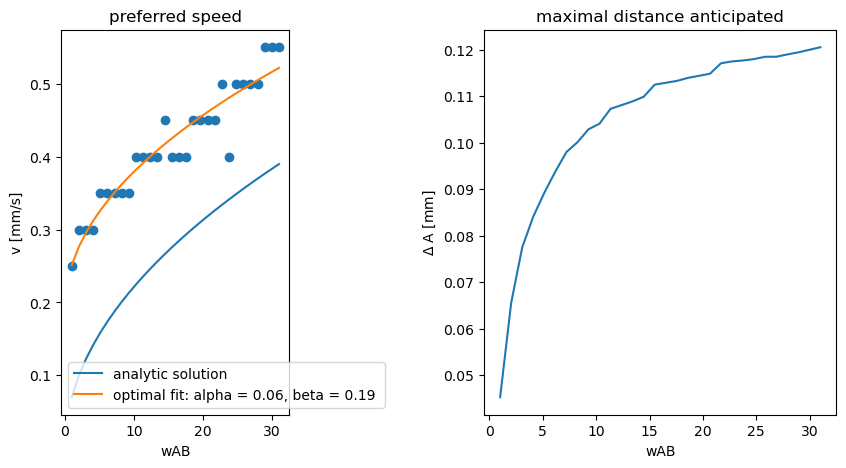

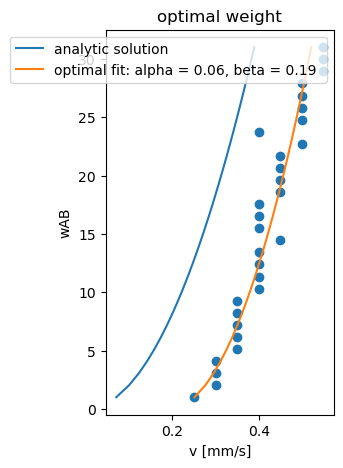

In [142]:
weights = np.asarray(weights)
pref_speeds = np.asarray(pref_speeds)

# def preferred_speed(wplus,wminus,delta):

#     return 2*np.sqrt(wplus*wminus)*delta

def preferred_speed(wplus,alpha,beta):

    return alpha*np.sqrt(wplus)+beta

popt,_ = curve_fit(preferred_speed,weights,pref_speeds)

fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(1,3,1)

ax.set_title('preferred speed')
plt.scatter(weights,pref_speeds)
plt.plot(weights, preferred_speed(weights,0.07,0), label  ='analytic solution')
plt.plot(weights, preferred_speed(weights,*popt), label  =f'optimal fit: alpha = {np.round(popt[0],2)}, beta = {np.round(popt[1],2)} ')
#plt.plot(weights, preferred_speed(weights,0.07,0.13), label  ='analytic solution + 0.13')

plt.xlabel('wAB')
plt.ylabel('v [mm/s]')
plt.legend()


ax = fig.add_subplot(1,2,2)
ax.set_title('maximal distance anticipated')
plt.plot(weights,pref_amp)
plt.xlabel('wAB')
plt.ylabel(r'$\Delta$ A [mm]')




fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(1,3,3)

ax.set_title('optimal weight')
plt.scatter(pref_speeds,weights)
plt.plot(preferred_speed(weights,0.07,0),weights, label  ='analytic solution')
plt.plot( preferred_speed(weights,*popt),weights, label  =f'optimal fit: alpha = {np.round(popt[0],2)}, beta = {np.round(popt[1],2)} ')
#plt.plot(weights, preferred_speed(weights,0.07,0.13), label  ='analytic solution + 0.13')

plt.ylabel('wAB')
plt.xlabel('v [mm/s]')
plt.legend()

# plot speedscaling for all tauAB relative difference

In [143]:

net = f'fb_linear'

# load dataframe 
response_data = pd.read_csv(f'{filepath}/responses_RG_tauABrel.csv')


# load dataframe 
df = pd.read_csv(f'{filepath}/anticipation_data_tauABrel.csv')


print(df.columns)

# calculate anticipation with respect to V_drive
df['ant_RG_drive_time']  =  df['peak_drive'] - df['peak_RG'] 
df['ant_RG_drive_space'] = df['ant_RG_drive_time']* df['speed']

# calculate anticipation with respect to 
df['ant_RG_bar_time']  = df['tp_rf_GC_mid'] - df['peak_RG'] 
df['ant_RG_bar_space'] = df['ant_RG_bar_time']* df['speed']

df['wTOT'] = -1*df['wTOT']
df['wTOT'] = df['wTOT'].round()
# multiple heatmaps, keeping w+ fixed and changing w-
#dfgrouped = df.groupby(['wAB'])


speeds = df['speed'].unique()#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0]

df['tauA'].unique()



Index(['Unnamed: 0', 'wTOT', 'tauTOT', 'wBA', 'wAB', 'tauA', 'tauB', 'mu',
       'speed', 'peak_RG', 'peak_RB', 'peak_drive', 'tp_rf_GC_mid',
       'peak_RG_pooling', 'peak_RB_pooling', 'onset_RB', 'onset_RG', 'x',
       'wGA'],
      dtype='object')


array([0.08695652, 0.0893655 , 0.09191176, 0.09460738, 0.09746589,
       0.10050251, 0.10373444, 0.10718114, 0.11086475, 0.11481056,
       0.11904762, 0.12360939, 0.1285347 , 0.13386881, 0.1396648 ,
       0.14619883, 0.15313936, 0.1607717 , 0.16920474, 0.17857143,
       0.18903592, 0.20080321, 0.21413276, 0.2293578 , 0.24691358,
       0.26737968, 0.29154519, 0.32051282, 0.35587189, 0.4       ])

1500 0.1
7.524916943521594
1000 0.15
5.016611295681062
750 0.2
3.7624584717607967
600 0.25
3.009966777408637
500 0.3
2.508305647840531
429 0.3500000000000001
2.1499762695775977
375 0.4000000000000001
1.881229235880398
334 0.45
1.6722037652270207
300 0.5000000000000001
1.5049833887043185
273 0.5500000000000002
1.368166717003926
250 0.6000000000000002
1.2541528239202653
231 0.6500000000000001
1.1576795297725528
215 0.7000000000000002
1.0749881347887988
200 0.7500000000000002
1.0033222591362123
188 0.8000000000000002
0.9406146179401992
177 0.8500000000000002
0.885284346296658
167 0.9000000000000002
0.8361018826135103
158 0.9500000000000004
0.7920965203706939
150 1.0000000000000004
0.7524916943521591
143 1.0500000000000005
0.716658756525866
137 1.1000000000000003
0.6840833585019628
131 1.1500000000000004
0.6543406037844863
125 1.2000000000000004
0.6270764119601326
120 1.2500000000000004
0.6019933554817274
116 1.3000000000000005
0.5788397648862763
112 1.3500000000000003
0.5574012550756734
1

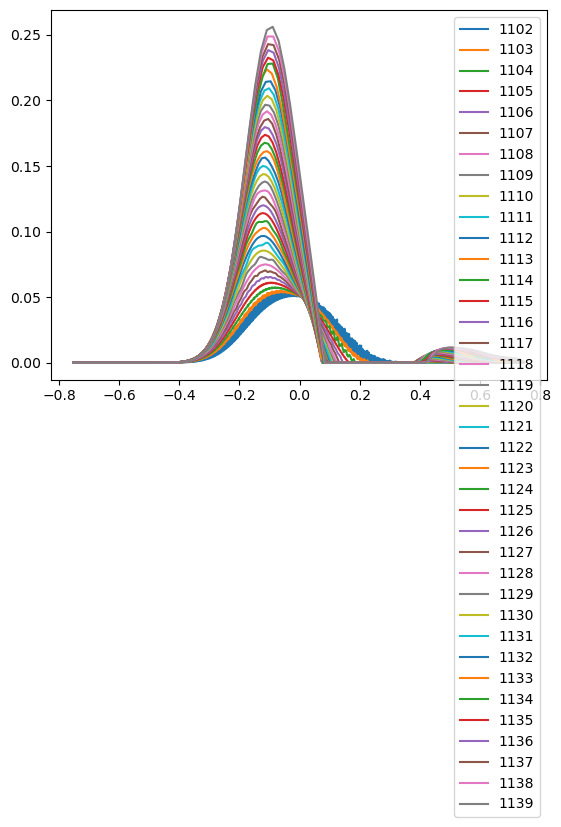

In [146]:
dl = df[df['tauA'] == 0.4]
#dl = df[df['wTOT'] == -101.0]
# dl = dl[dl['speed'] == 1.0 ]
idx = dl['ant_RG_bar_space'].index
len(idx)


for x,i in enumerate(idx):


    r = response_data[f'{i}'].dropna()
    tps = len(r)
    speed = dl['speed'][dl.index[x]]
    print(tps,speed)
    tpm = dl['tp_rf_GC_mid'][dl.index[x]]
    print(tpm)
    time = (np.arange(0,tps)*0.01 -tpm)*speed
    plt.plot(time,r,label = f'{i}')
plt.legend()

/tmp/ipykernel_970025/1058637848.py:27: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sg = subg.get_group(w2)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


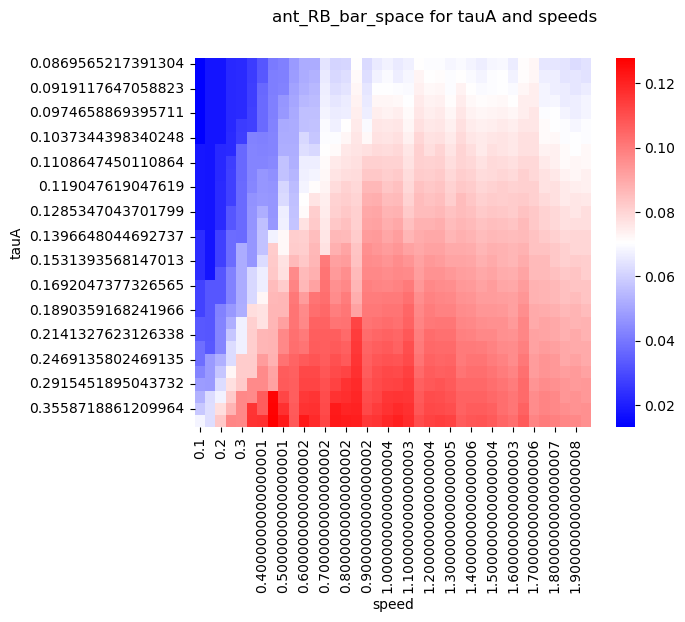

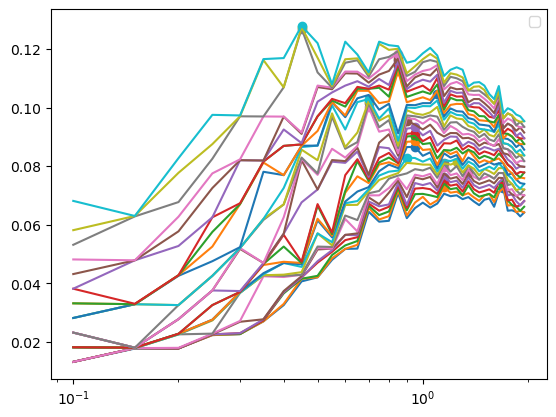

In [147]:
fig = plt.figure()
fig.tight_layout()
fig.suptitle(f'{var} for tauA and speeds')

var = 'ant_RG_bar_space'

fig2 = plt.figure()
fig2.tight_layout()
#weights = [0.0,10.0,50.0,100.0]

ax = fig.add_subplot(1,1,1)
# plot heatmap for beta
g_heatmap = df.pivot_table(index = 'tauA',columns = 'speed',values = var, aggfunc = 'mean')
sns.heatmap(g_heatmap, ax = ax, cmap = 'bwr')#,  vmin=-0.2, vmax=0.2)

subg = df.groupby(['tauA'])
ax = fig2.add_subplot(1,1,1)
ax.set_xscale('log')


# get values for which difference across speed is minimal
diffsdf = pd.DataFrame(columns = ['diff', 'mu','wTOT','tauTOT', 'tauA', 'wBA'])


# get values that yield same anticipation time across speeds
for x,w2 in enumerate(subg.groups):
    sg = subg.get_group(w2)

    cur  = sg[var].values
    speeds = sg['speed'].values
    maxi = np.argmax(cur)
    ax.plot(sg['speed'], sg[var])
    ax.scatter(speeds[maxi],cur[maxi])
    # diff = np.mean(np.abs(np.diff(sg[var])))
    # data = {'diff': diff,
    #         'mu' : w2,
    #         'wTOT': sg['wTOT'].min(),
    #         'tauTOT': sg['tauTOT'].min(),
    #         'tauA':sg['tauA'],
    #         'wBA': sg['wBA']}
    # diffsdf = diffsdf._append(data, ignore_index = True)

ax.legend()



# speedscaling for all tauAB with relative difference changing

In [148]:

net = f'fb_linear'

# load dataframe 
response_data = pd.read_csv(f'{filepath}/responses_RG_tauABabs.csv')


# load dataframe 
df = pd.read_csv(f'{filepath}/anticipation_data_tauABabs.csv')


print(df.columns)

# calculate anticipation with respect to V_drive
df['ant_RG_drive_time']  =  df['peak_drive'] - df['peak_RG'] 
df['ant_RG_drive_space'] = df['ant_RG_drive_time']* df['speed']

# calculate anticipation with respect to 
df['ant_RG_bar_time']  = df['tp_rf_GC_mid'] - df['peak_RG'] 
df['ant_RG_bar_space'] = df['ant_RG_bar_time']* df['speed']

df['wTOT'] = -1*df['wTOT']
df['wTOT'] = df['wTOT'].round()
# multiple heatmaps, keeping w+ fixed and changing w-
#dfgrouped = df.groupby(['wAB'])


speeds = df['speed'].unique()#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0]

df['tauA'].unique()



Index(['Unnamed: 0', 'wTOT', 'tauTOT', 'wBA', 'wAB', 'tauA', 'tauB', 'mu',
       'speed', 'peak_RG', 'peak_RB', 'peak_drive', 'tp_rf_GC_mid',
       'peak_RG_pooling', 'peak_RB_pooling', 'onset_RB', 'onset_RG', 'wGA'],
      dtype='object')


array([0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.15,
       0.16, 0.18, 0.19, 0.21, 0.23, 0.25, 0.27, 0.3 , 0.33, 0.37, 0.41,
       0.45, 0.51, 0.57, 0.65, 0.74])

In [149]:
df['wBA'],df['wAB']

(0       10.0
 1       10.0
 2       10.0
 3       10.0
 4       10.0
         ... 
 1135    10.0
 1136    10.0
 1137    10.0
 1138    10.0
 1139    10.0
 Name: wBA, Length: 1140, dtype: float64,
 0       10.0
 1       10.0
 2       10.0
 3       10.0
 4       10.0
         ... 
 1135    10.0
 1136    10.0
 1137    10.0
 1138    10.0
 1139    10.0
 Name: wAB, Length: 1140, dtype: float64)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


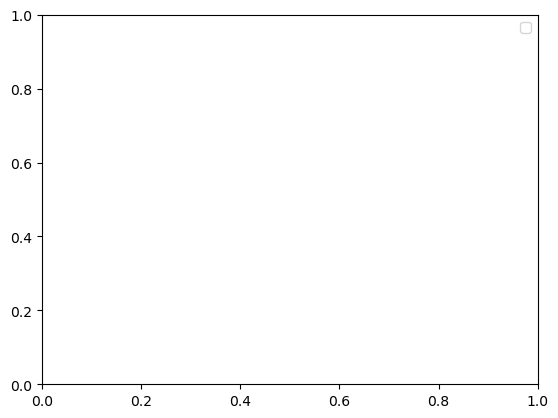

In [150]:
dl = df[df['tauA'] == 0.74468085]
#dl = df[df['wTOT'] == -101.0]
# dl = dl[dl['speed'] == 1.0 ]
idx = dl['ant_RG_bar_space'].index
len(idx)


for x,i in enumerate(idx):


    r = response_data[f'{i}'].dropna()
    tps = len(r)
    speed = dl['speed'][dl.index[x]]
    print(tps,speed)
    tpm = dl['tp_rf_GC_mid'][dl.index[x]]
    print(tpm)
    time = (np.arange(0,tps)*0.01 -tpm)*speed
    plt.plot(time,r,label = f'{i}')
plt.legend()

/tmp/ipykernel_970025/739001282.py:27: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sg = subg.get_group(w2)


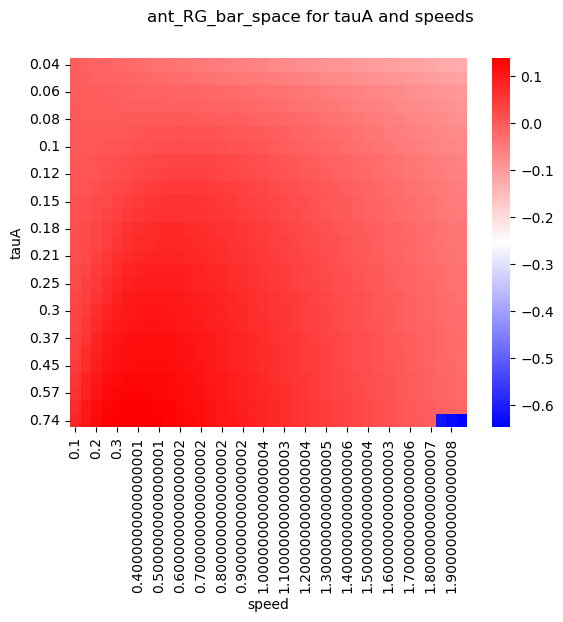

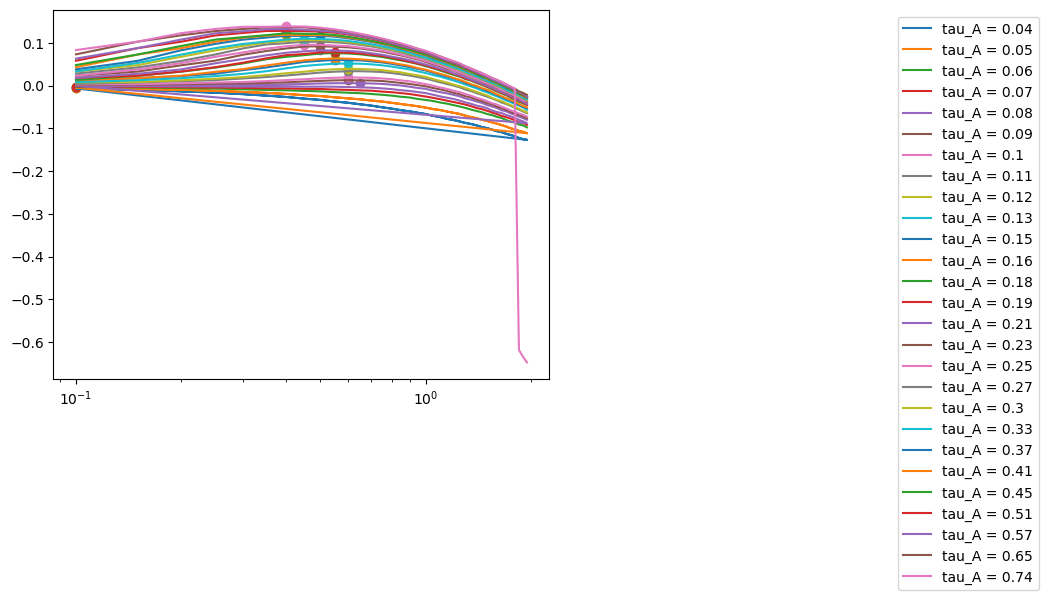

In [151]:
fig = plt.figure()
fig.tight_layout()
fig.suptitle(f'{var} for tauA and speeds')


fig2 = plt.figure()
fig2.tight_layout()
#weights = [0.0,10.0,50.0,100.0]

ax = fig.add_subplot(1,1,1)
# plot heatmap for beta
g_heatmap = df.pivot_table(index = 'tauA',columns = 'speed',values = var, aggfunc = 'mean')
sns.heatmap(g_heatmap, ax = ax, cmap = 'bwr')#,  vmin=-0.2, vmax=0.2)

subg = df.groupby(['tauA'])
ax = fig2.add_subplot(1,1,1)
ax.set_xscale('log')


# get values for which difference across speed is minimal
diffsdf = pd.DataFrame(columns = ['diff', 'mu','wTOT','tauTOT', 'tauA', 'wBA'])


# get values that yield same anticipation time across speeds
for x,w2 in enumerate(subg.groups):
    if x < 29:
        sg = subg.get_group(w2)

        cur  = sg[var].values
        speeds = sg['speed'].values
        maxi = np.argmax(cur)
        ax.plot(sg['speed'], sg[var],label = f'tau_A = {w2}')
        ax.scatter(speeds[maxi],cur[maxi])
    # diff = np.mean(np.abs(np.diff(sg[var])))
    # data = {'diff': diff,
    #         'mu' : w2,
    #         'wTOT': sg['wTOT'].min(),
    #         'tauTOT': sg['tauTOT'].min(),
    #         'tauA':sg['tauA'],
    #         'wBA': sg['wBA']}
    # diffsdf = diffsdf._append(data, ignore_index = True)

ax.legend(loc = 'upper right', bbox_to_anchor = (2.,1.))

